In [36]:
import os 
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT +  "datasets/housing/housing.tgz"

# a function to fetch the data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [37]:
import pandas as pd

# Loading Housing Data
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [38]:
housing = load_housing_data()

# general info about the data
general_info = housing.info()


# getting first few elements
# head = housing.head()
# print(head)


# print(housing["ocean_proximity"].value_counts())

# summary of each numerical attribute
# housing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


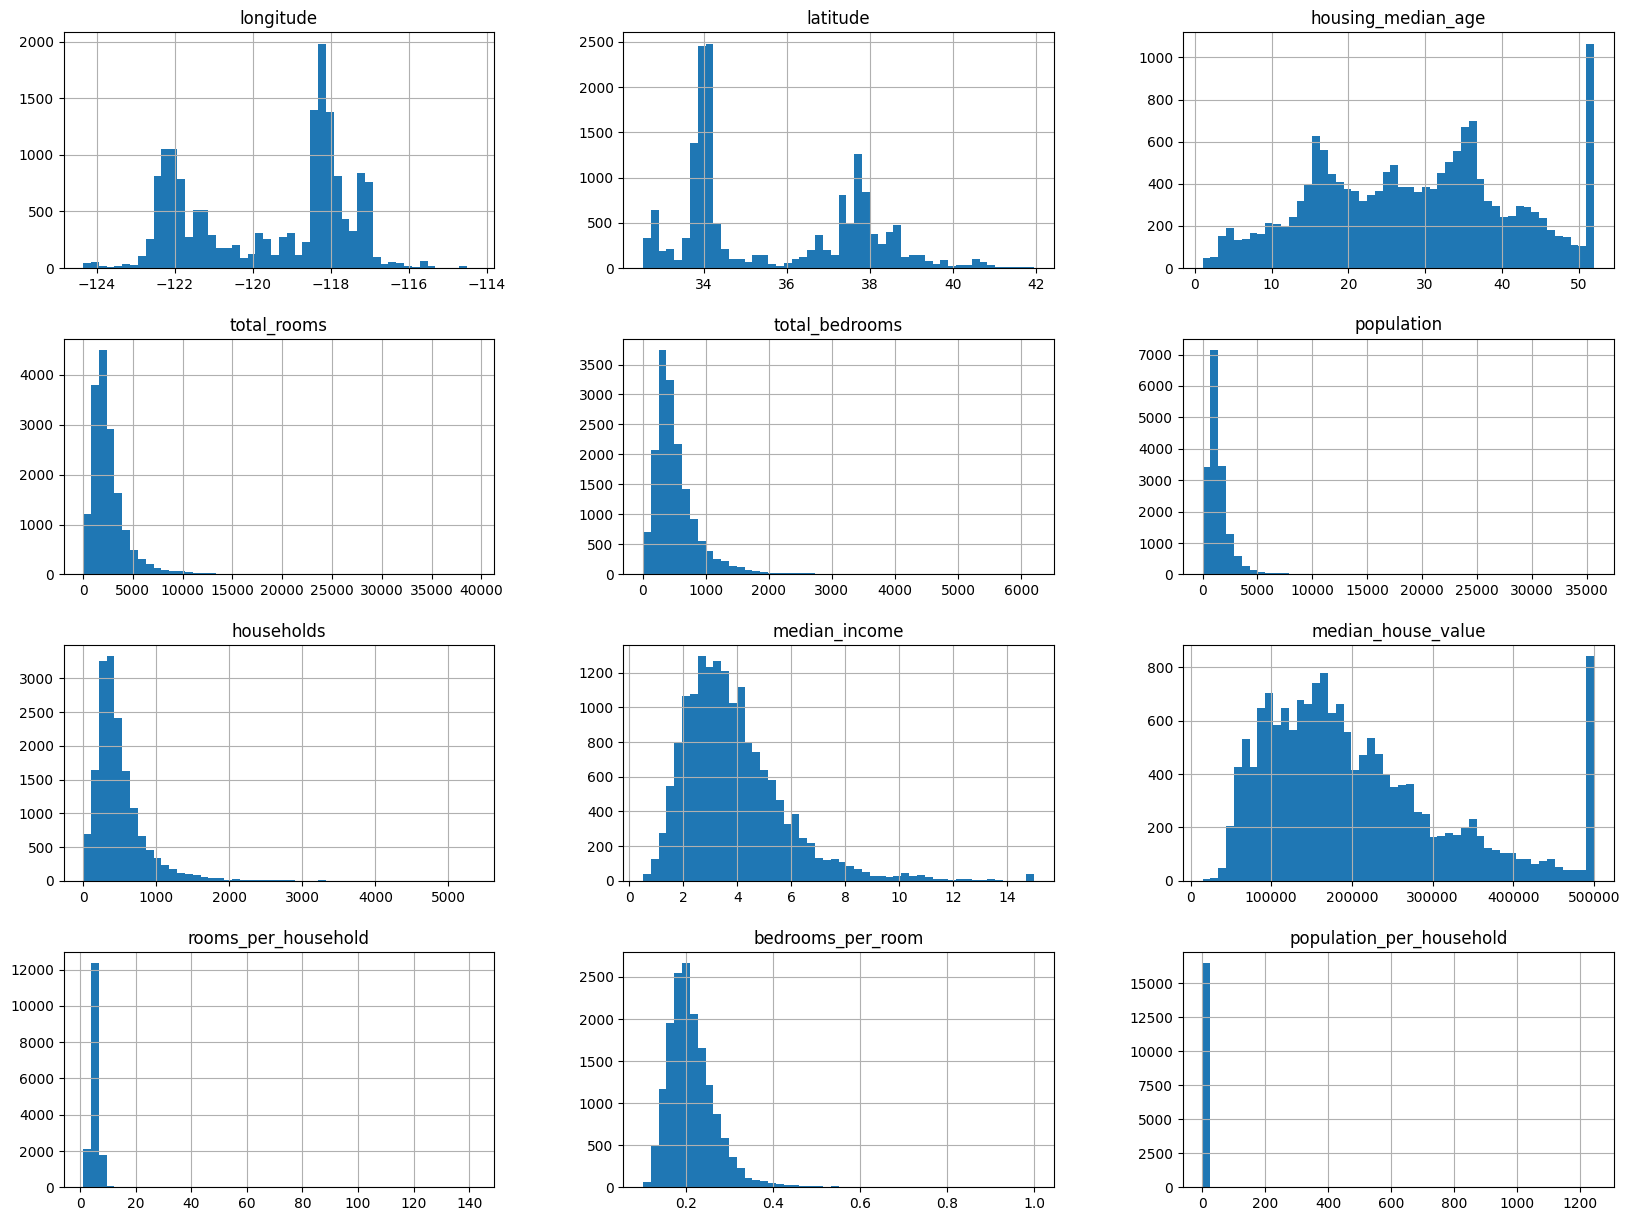

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt


# we can plot a histogram for each numerical attribute
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [6]:
import numpy as np

# creating a test set
# def split_train_test(data, test_ratio):
#     shuffled_indices = np.random.permutation(len(data))
#     test_set_size = int(len(data) * test_ratio)
#     test_indices = shuffled_indices[: test_set_size]
#     train_indices = shuffled_indices[test_set_size:]
#     return data.iloc[train_indices], data.iloc[test_indices]


# train_set, test_set = split_train_test(housing, 0.2)

# print(f"Train Set shape: {len(train_set)}") #16512
# print(f"Test Set shape: {len(test_set)}") #4128

In [7]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

print(f"Train Set shape: {len(train_set)}") #16512
print(f"Test Set shape: {len(test_set)}") #4128

Train Set shape: 16512
Test Set shape: 4128


In [8]:
# Stratified Sampling using median income as an important feature
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0, 1.5, 3.0, 4.5, 6., np.inf], 
                               labels=[1,2,3,4,5,])

<Axes: >

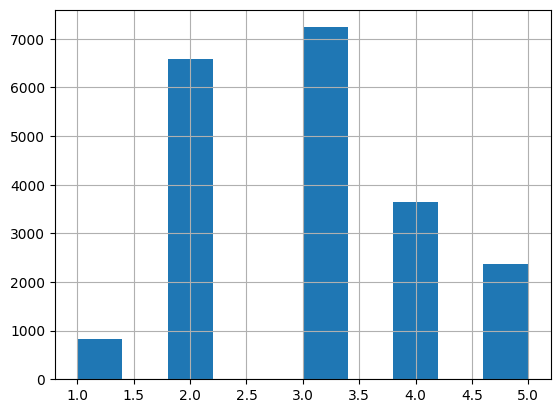

In [9]:
housing["income_cat"].hist()


In [10]:
# Now we can do stratified sampling based on the income category
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
# print(f"Strat Train shape: {strat_train_set.shape}\nStrat Test shape: {strat_test_set.shape}")

# Income category proportion in the train set
# print(strat_train_set["income_cat"].value_counts() / len(strat_train_set))

# Income category proportion in the test set
# print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))


    

In [11]:
# Now we should remove the income_cat
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


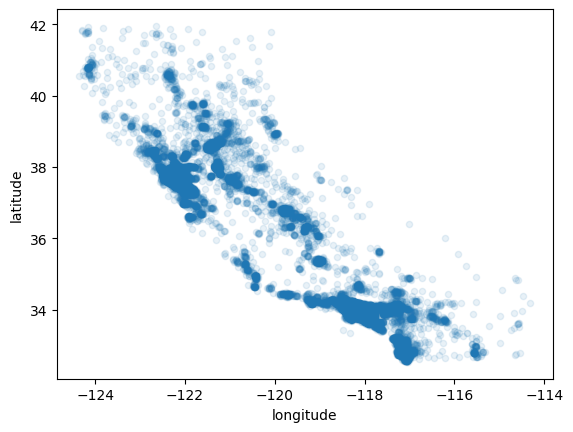

In [22]:
# Visualizing Data

# Geographical Data
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

In [13]:
# More detailed visualization
# s indicates the size of the population
# c color of the median income
# plt.close()
# housing.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.4, 
#                 s=housing["population"]/100, label="population", figsize=(10,7),
#                 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
#             )
# plt.legend()
# plt.show()

In [14]:
# looking for correlations
# corr values ranges from -1 to 1
# corr close to 1 - means there is a strong +ve correlation
# corr close to -1 - means there is a strong -ve correlation
# corr close to 0 - means there is no linear correlation
corr_matrix = housing.corr(numeric_only=True)
print(corr_matrix["median_house_value"].sort_values(ascending=False))



median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


In [15]:
# using pandas scatter-matrix() to get correlation among most important features
from pandas.plotting import scatter_matrix

# attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
# scatter_matrix(housing[attributes], figsize=(12,8))
# plt.show()

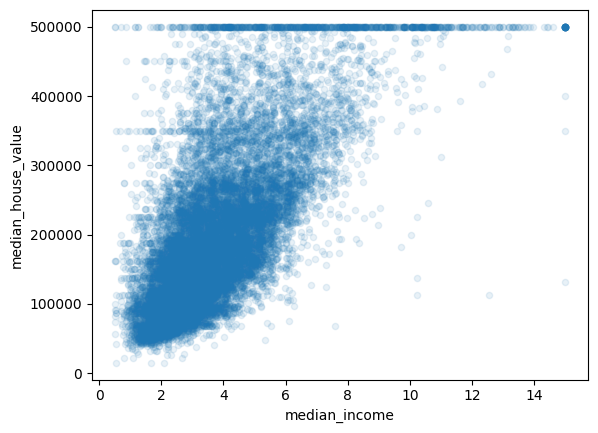

In [16]:
# The most important correlation is among median_income and median_house_value

housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

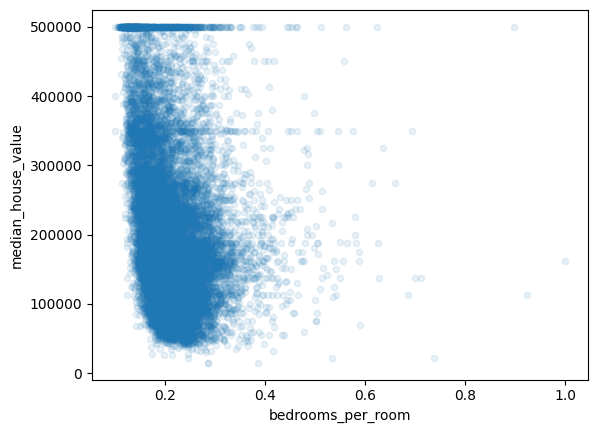

In [23]:
# Attribute combination for better correlation with target value
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

housing.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value", alpha=0.1)
plt.show()

In [33]:
# handling missing values (total bedrooms)
median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)
# housing.info()


In [44]:
# sklearn implementation of handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") # imputer is called estimator

# removing non numeric features
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num) # the result is plain numpy array
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [60]:
# handling text and catagorical attributes
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10) # this attribute is categorical

#by using ordinal encoder from sklearn we can conver it to numerical attribute
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
# housing_cat_encoded[:10]
ordinal_encoder.categories_



[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [76]:
# to handle and categorise similar attributes we can use one hot encoding
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot =  cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray() # shape will be (20640,5) creating 5 new hot encoded categroies
cat_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [85]:
# Feature Scaling
# ML algorithms couldn't perform well if the feature scale have greate difference
bed_rooms = housing["total_bedrooms"]
print(bed_rooms.min()) # 1.0
print(bed_rooms.max()) # 6445.0

1.0
6445.0
